# 1、加载数据，定义生成图像集路径txt文档的函数
##### （1）因为每个汉字的图像集都存放在对应的数字编号文件夹中，所以读取路径总共有100条。
##### （2）通过手动输入每个文件的路径需要极大的工作量，因此可以创建每个汉字的图像路径txt文件，并通过遍历txt中保存的路径读取图像。


In [7]:
# 导入必要的库
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
%pip install torchsummary
from torchsummary import summary
from PIL import Image

# 定义一个函数用来创建一个包含图像路径的txt文件
def classes_txt(root, out_path, num_class=None):
    # os.listdir(root) 列出给定根目录下所有项目（目录和文件）
    dirs = os.listdir(root)  
    # 如果没有指定类别数量，就使用目录中项目的数量作为类别数量
    if not num_class:       
        num_class = len(dirs)
    # 如果输出路径不存在，创建一个新的文本文件
    if not os.path.exists(out_path): 
        f = open(out_path, 'w')
        f.close()

    # 以读写模式打开文件，这允许在文件末尾追加内容
    with open(out_path, 'r+') as f:
        try:
            # 尝试读取文件最后一行，并获取最后一个类别的索引
            end = int(f.readlines()[-1].split('/')[-2]) + 1
        except:
            # 如果读取失败（例如文件是空的），设置起始索引为0
            end = 0
        # 如果文件中已有的类别数少于需要的类别数
        if end < num_class - 1:
            # 对目录进行排序，确保顺序一致性
            dirs.sort()
            # 只选择还没有被写入文件的类别目录
            dirs = dirs[end:num_class]
            for dir in dirs:
                # 列出当前类别目录下的所有文件
                files = os.listdir(os.path.join(root, dir))
                for file in files:
                    # 将每个文件的完整路径写入到txt文件中
                    f.write(os.path.join(root, dir, file) + '\n')

Note: you may need to restart the kernel to use updated packages.


# 2、定义读取并变换图像数据格式的类

In [8]:
# 导入必要的库
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

# 自定义的数据集类
class MyDataset(Dataset):
    def __init__(self, txt_path, num_class, transforms=None):
        super(MyDataset, self).__init__()
        images = []  # 用于存储图像文件的路径
        labels = []  # 用于存储图像对应的类别

        # 打开包含图像路径的文本文件
        with open(txt_path, 'r') as f:
            for line in f:
                # 从文件路径中解析出类别编号（假设路径格式是 folder\class\image.jpg）
                class_id = int(line.split('\\')[-2])
                # 如果类别编号大于或等于指定的类别数，停止读取
                if class_id >= num_class:
                    break
                # 移除行尾的换行符，并添加到图像列表
                line = line.strip('\n')
                images.append(line)
                # 添加类别编号到标签列表
                labels.append(class_id)
        
        self.images = images  # 图像路径列表
        self.labels = labels  # 图像标签列表
        self.transforms = transforms  # 图像预处理转换函数

    def __getitem__(self, index): #就是一次读取图片和标签
        # 根据索引获取图像路径，并用PIL库加载图像
        image = Image.open(self.images[index]).convert('RGB')
        # 获取对应的标签
        label = self.labels[index]
        # 如果有传入转换函数，则对图像进行转换
        if self.transforms:
            image = self.transforms(image)
        return image, label  # 返回图像和标签

    def __len__(self):
        # 返回数据集中的图像总数
        return len(self.labels)

# 3、加载图像数据

In [9]:
# 首先将训练集和测试集文件途径和文件名以txt保存在一个文件夹中，路径自行定义
root = 'data'  # 文件的储存位置
classes_txt(root + '/train', root+'/train.txt')
classes_txt(root + '/test', root+'/test.txt')

# 由于数据集图片尺寸不一，因此要进行resize（重设大小）
# 将图片大小重设为 64 * 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform=transforms.Compose([
    transforms.Resize((64,64)), #重设大小，将所有的图片大小都Resize为（64，64），因为神经网络就相当于一个矩阵，要求维度一致，否则报错
    transforms.Grayscale(),#将原始的彩色rgb转换为灰色,因为我们这个任务黑白色就够了
    transforms.ToTensor()
])

#提取训练集和测试集图片的路径生产txt文件
#num_class选取100种汉字  提出图片和标签
train_set=MyDataset(root+'/train.txt',num_class=100,transforms=transform)
test_set=MyDataset(root+'/test.txt',num_class=100,transforms=transform)

#将数据集放到数据迭代器中
train_loader=DataLoader(train_set,batch_size=32,shuffle=True)
test_loader=DataLoader(test_set,batch_size=32,shuffle=False)

#我们后面需要
for step,(x,y) in enumerate(test_loader):
    test_x,labels_test=x.to(device),y.to(device)

ValueError: num_samples should be a positive integer value, but got num_samples=0

# 4、定义模型架构

In [ ]:
class MYNET(nn.Module):
    def __init__(self):
        super(MYNET, self).__init__()
        #参数分别是输入通道数，输出通道数，卷积核大小
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3) #输入1是因为是黑白图片
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2704, 512)
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, 100)
    def forward(self,x):  #输出的维度大小应该是[32,100]
        x = self.pool(F.relu(self.conv1(x)))  #图像尺寸从64x64变为(64-3+1-2*2)/2 + 1 = 32x32（因为kernel_size=3，stride=2）。
        x = self.pool(F.relu(self.conv2(x)))  #图像尺寸从32x32变为(32-5+1-2*2)/2 + 1 = 14x14（因为kernel_size=5，stride=2）
        x=x.view(-1,2704) #因此，卷积层的输出特征图大小为14x14x16（因为输出通道数为16），所以展平后的向量大小为14*14*16 = 2704
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model=MYNET().to(device)
summary(model,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 62, 62]              60
         MaxPool2d-2            [-1, 6, 31, 31]               0
            Conv2d-3           [-1, 16, 27, 27]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Linear-5                  [-1, 512]       1,384,960
            Linear-6                   [-1, 84]          43,092
            Linear-7                  [-1, 100]           8,500
Total params: 1,439,028
Trainable params: 1,439,028
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.33
Params size (MB): 5.49
Estimated Total Size (MB): 5.84
----------------------------------------------------------------


# 5、定义学习率，优化器和损失函数

In [ ]:
import torch.optim as optim
import numpy as np 
# 定义学习率调整函数，加入学习率衰减
def adjust_learning_rate(epoch, learning_rate, lr_decay_rate, lr_decay_epochs, optimizer):
    """
    根据epoch动态调整学习率：
    - 如果当前epoch超过了指定的衰减节点，则学习率按比例递减。
    - 否则保持初始学习率。

    Parameters:
    - epoch: 当前训练周期数（从0开始）。
    - learning_rate: 初始学习率。
    - lr_decay_rate: 学习率衰减因子，每次衰减乘以该因子。
    - lr_decay_epochs: 包含学习率衰减的epoch节点列表。
    - optimizer: 优化器对象，其内部管理参数学习率。

    Returns:
    - 当前更新后的学习率。
    """
    # 检查当前epoch是否超过衰减节点
    steps = np.sum(epoch > np.asarray(lr_decay_epochs))
    
    if steps > 0:
        # 如果超过衰减节点，根据衰减次数steps计算新的学习率
        new_lr = learning_rate * (lr_decay_rate ** steps)
    else:
        # 如果未达到衰减节点，保持初始学习率
        new_lr = learning_rate

    # 更新优化器内部的参数组学习率
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

    return new_lr  # 返回当前学习率，用于日志记录或调试

initial_lr=0.001  #初始的学习率，之后学习率越来越低
lr_decay_rate=0.1  #每一次衰减之后学习率变为之前的0.1（10%）
lr_decay_epochs=[1,2,3]   #
num_epochs=4  #训练总的迭代数

# 定义损失函数和优化器
#定义交叉熵损失函数,常用于多分类问题
loss_func=nn.CrossEntropyLoss() 
#定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# 6、训练和评估网络

In [ ]:
# 训练模型
c=0
for epoch in range(num_epochs):
    # 调整学习率
    current_lr = adjust_learning_rate(epoch, initial_lr, lr_decay_rate, lr_decay_epochs, optimizer)
    # 打印当前学习率
    print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {current_lr:.6f}")
        
    for step,(x,y) in enumerate(train_loader):
        picture,labels=x.to(device),y.to(device)
        output=model(picture)
        # print(output.shape)
        loss=loss_func(output, labels)
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()

        #性能评估
        if step % 50==0:
            test_output=model(test_x)
            pred_y=torch.max(test_output,1)[1].data.squeeze()
            accuracy=((pred_y==labels_test).sum().item() / labels_test.size(0))
            #输出迭代次数，训练误差，测试准确率
            print(f'迭代次数 [{epoch}], 训练损失: {loss:.4f}, 测试准确率: {accuracy:.2%}')
            if accuracy>c:
                c=accuracy
                a=epoch
                b=loss
print(f'最佳的迭代次数 [{a}], 最佳的训练损失: {b:.4f}, 最佳的测试准确率: {c:.2%}')
print('完成训练')


# 保存模型
torch.save(model.state_dict(),'data/tmp/model.pkl')

Epoch [1/4], Learning Rate: 0.001000
迭代次数 [0], 训练损失: 0.3778, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.8789, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.4497, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.6362, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.4406, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.4256, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.8702, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.5535, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 1.1018, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.6453, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.4300, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.5674, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.5085, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.6691, 测试准确率: 85.71%
迭代次数 [0], 训练损失: 0.6184, 测试准确率: 85.71%
Epoch [2/4], Learning Rate: 0.001000
迭代次数 [1], 训练损失: 0.5399, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 1.1102, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.8494, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.6552, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.4646, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.8688, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.4283, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.7086, 测试准确率: 85.71%
迭代次数 [1], 训练损失: 0.6125, 测试准确率: 85.71%
迭代次数 [1], 训练损失

# 7、演示实验效果

In [ ]:
# 泛化测试
# 测试图像处理
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.Grayscale(),
                                transforms.ToTensor()])

#加载模型
model=MYNET()
model.load_state_dict(torch.load('data/tmp/model.pkl'))
model.eval()

#输入图片并预测
img=Image.open('data/test/00008/816.png')
img=transform(img)
img=img.view(1,1,64,64)
output=model(img)
_,prediction=torch.max(output,1)
prediction=prediction.numpy()[0]
print(prediction)

8


C:\Users\user\AppData\Local\Temp\ipykernel_11036\2269947494.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/tmp/model.pkl'))


# 8、评估完整的测试集效果

测试集准确率: 76.59%


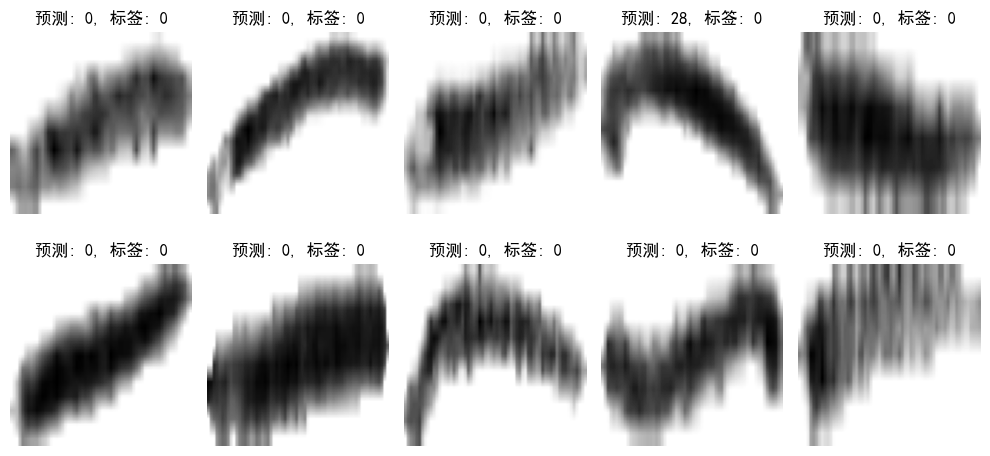

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 模型评估
model.eval()  #冻结模型，用于评估
# 用于存储预测结果和实际标签
all_preds = []
all_labels = []

# 禁用梯度计算
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 计算准确率
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'测试集准确率: {accuracy:.2%}')

# 如果需要，可以绘制一些图像来可视化模型预测与实际数据的对比
# 例如，绘制前几个测试样本的预测与实际标签
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_set[i][0].permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(f'预测: {all_preds[i]}, 标签: {all_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()